<a href="https://colab.research.google.com/github/vedantgadhvi/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction Project

This notebook predicts customer churn using machine learning models and interprets results using SHAP values.

**Step 1: - Setup and Installation**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install pinecone sentence-transformers umap-learn optuna lightgbm plotly shap lime imbalanced-learn lifelines -q

print("✅ All packages installed successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.2 MB/s eta 0:00:00
✅ All packages installed successfully!


**Step 2: - Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import lightgbm as lgb

# Interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Vector Database (Updated Pinecone import)
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
import umap

# Advanced Analytics
from lifelines import KaplanMeierFitter
import optuna
from imblearn.over_sampling import SMOTE

# Utilities
import time
from datetime import datetime
import json

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("📚 All libraries imported successfully!")

📚 All libraries imported successfully!


**Step 3: - Basic Data Exploration**

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Customer Churn Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\n📋 Dataset Info:")
df.info()

print("\n📈 Target Variable Distribution:")
print(df['Churn'].value_counts())
print(f"Churn rate: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")

# Display first few rows
df.head()

🔍 DATASET OVERVIEW
Dataset shape: (7043, 21)
Missing values: 0
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   Inter

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Step 4: - Advanced Exploratory Data Analysis**

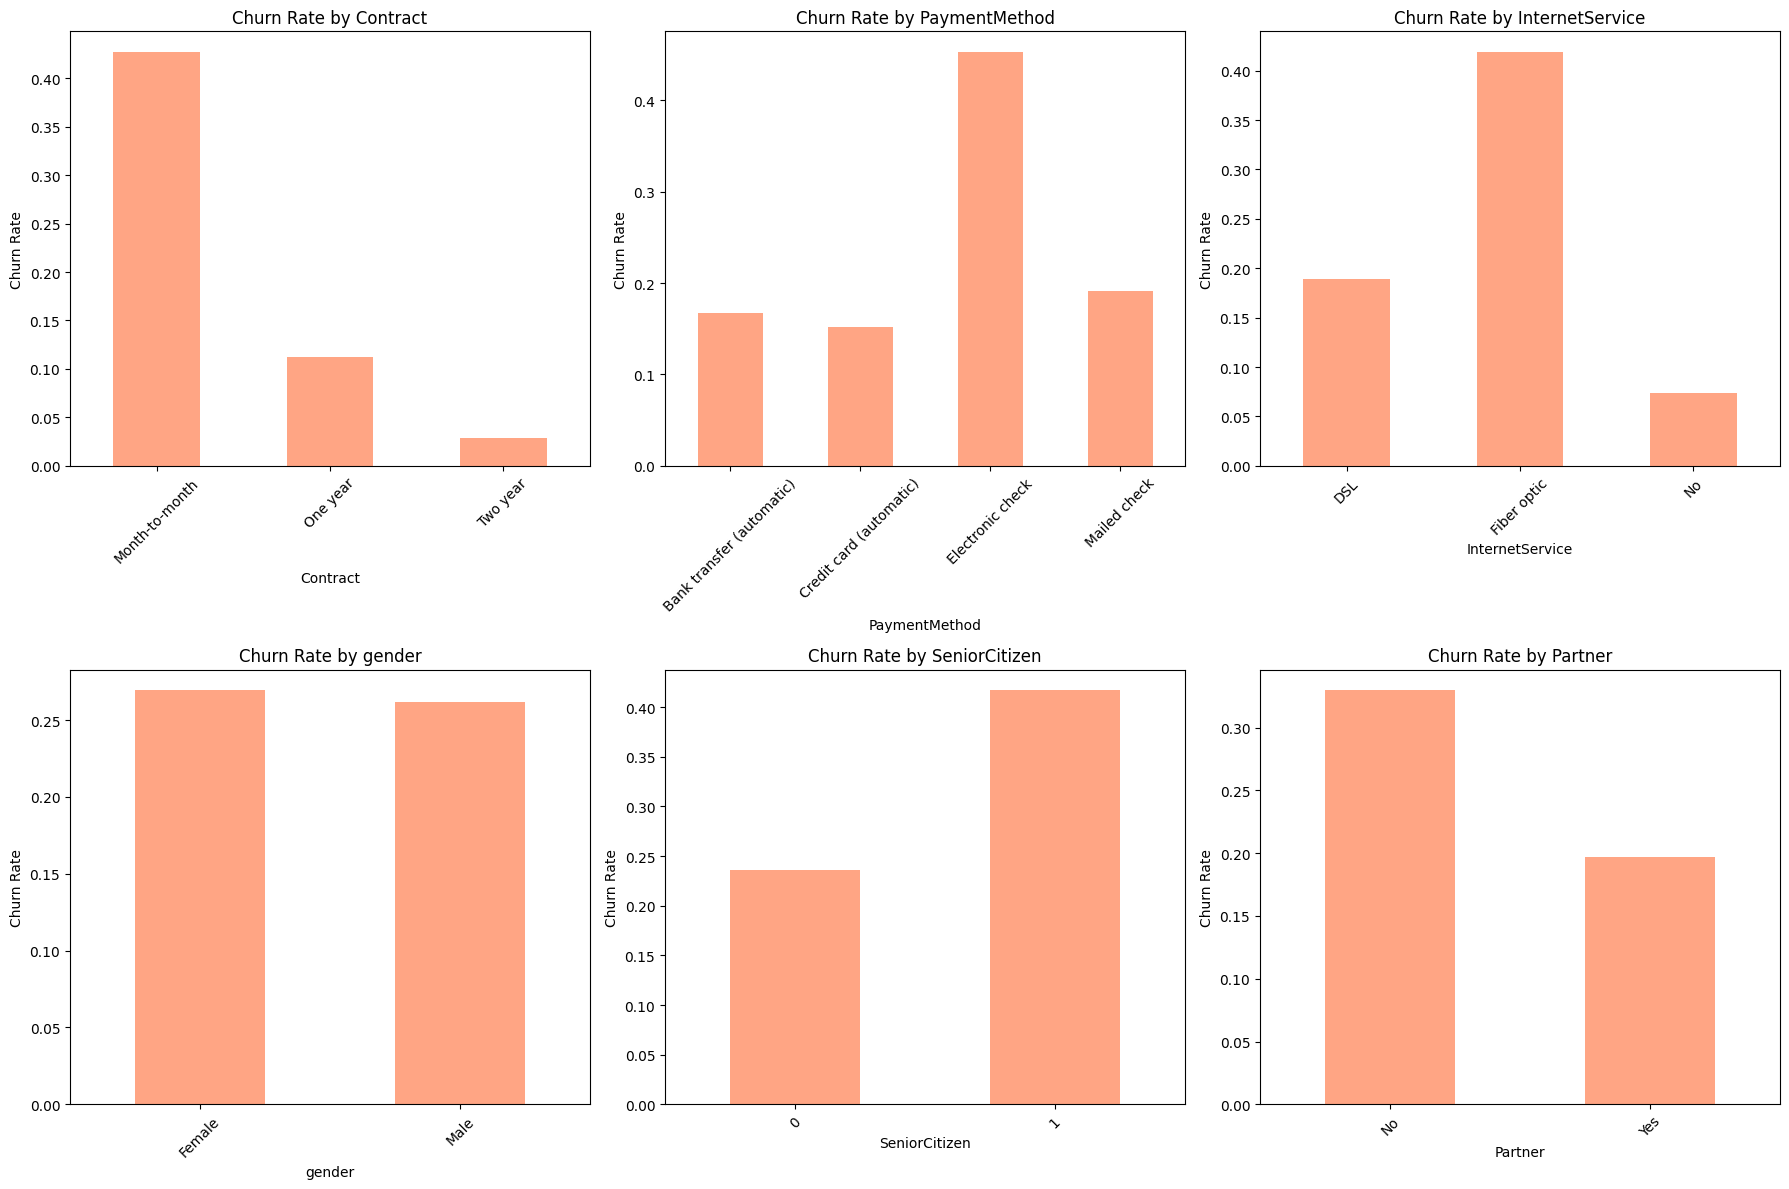

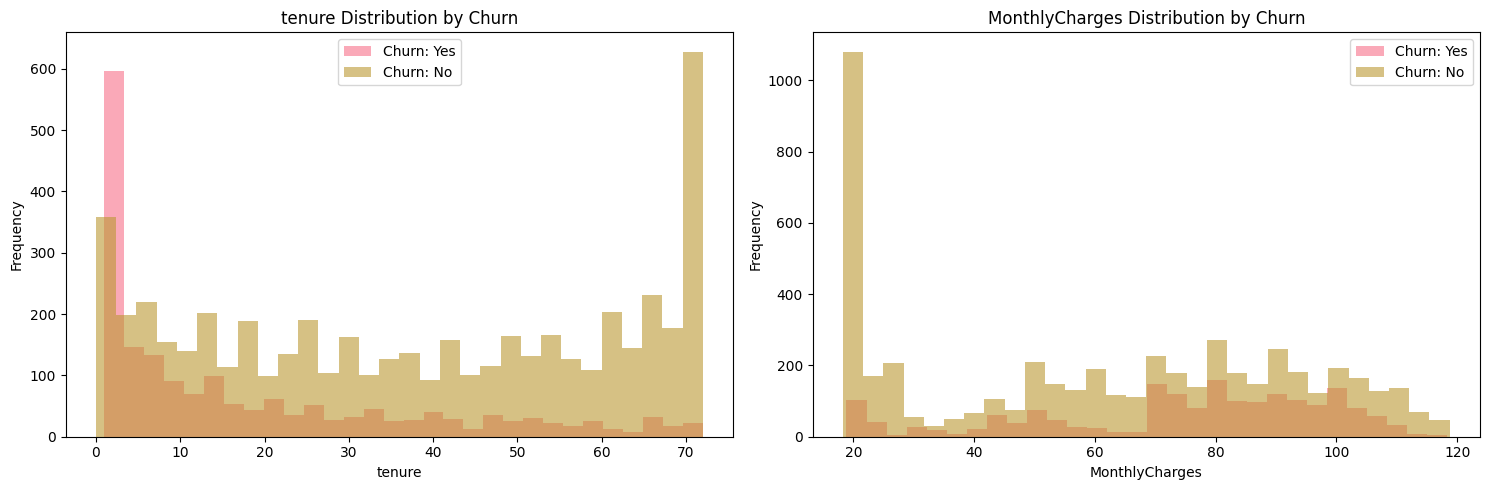

In [ ]:
def create_advanced_eda(df):
    """Create comprehensive visualizations"""

    # 1. Churn rate by categorical variables
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    categorical_vars = ['Contract', 'PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen', 'Partner']

    for i, var in enumerate(categorical_vars):
        row, col = i // 3, i % 3
        churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean())
        churn_rate.plot(kind='bar', ax=axes[row, col], color='coral', alpha=0.7)
        axes[row, col].set_title(f'Churn Rate by {var}')
        axes[row, col].set_ylabel('Churn Rate')
        axes[row, col].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 2. Numerical features distribution by churn
    numerical_cols = ['tenure', 'MonthlyCharges']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, col in enumerate(numerical_cols):
        for churn_status in ['Yes', 'No']:
            subset = df[df['Churn'] == churn_status][col]
            axes[i].hist(subset, alpha=0.6, label=f'Churn: {churn_status}', bins=30)

        axes[i].set_title(f'{col} Distribution by Churn')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # 3. Interactive plotly visualization
    fig = px.box(
        df,
        x='Contract',
        y='MonthlyCharges',
        color='Churn',
        title='Monthly Charges Distribution by Contract Type and Churn Status'
    )
    fig.show()

    # 4. Services analysis
    service_cols = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

    service_data = []
    for service in service_cols:
        for churn_status in ['Yes', 'No']:
            rate = (df[df['Churn'] == churn_status][service] == 'Yes').mean()
            service_data.append({
                'Service': service,
                'Churn': churn_status,
                'Adoption_Rate': rate
            })

    service_df = pd.DataFrame(service_data)

    fig = px.bar(
        service_df,
        x='Service',
        y='Adoption_Rate',
        color='Churn',
        barmode='group',
        title='Service Adoption Rates by Churn Status'
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# Run advanced EDA
create_advanced_eda(df)

**Step 5: - Data Preprocessing and Feature Engineering**

In [ ]:
def preprocess_and_engineer_features(df):
    """Comprehensive data preprocessing and feature engineering"""

    df_processed = df.copy()

    print("🔧 Starting feature engineering...")

    # 1. Handle missing values and data types
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    missing_total_charges = df_processed['TotalCharges'].isnull().sum()
    print(f"   Missing TotalCharges: {missing_total_charges}")
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

    # 2. Target encoding
    df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

    # 3. Remove customer ID
    df_processed.drop(['customerID'], axis=1, inplace=True)

    # 4. Advanced Feature Engineering

    # Service utilization features
    service_cols = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

    for col in service_cols:
        df_processed[f'{col}_Binary'] = (df_processed[col] == 'Yes').astype(int)

    # Aggregate service features
    df_processed['TotalServices'] = df_processed[[f'{col}_Binary' for col in service_cols]].sum(axis=1)
    df_processed['ServiceUtilizationRate'] = df_processed['TotalServices'] / len(service_cols)

    # Financial features
    df_processed['AvgMonthlySpend'] = df_processed['TotalCharges'] / (df_processed['tenure'] + 1)
    df_processed['ChargesPerService'] = df_processed['MonthlyCharges'] / (df_processed['TotalServices'] + 1)
    df_processed['SpendingEfficiency'] = df_processed['TotalCharges'] / (df_processed['MonthlyCharges'] + 1)

    # Customer lifecycle features
    df_processed['TenureGroup'] = pd.cut(df_processed['tenure'],
                                        bins=[-1, 12, 24, 48, 72],
                                        labels=['New', 'Growing', 'Mature', 'Loyal'])

    df_processed['CustomerValue'] = (df_processed['MonthlyCharges'] * df_processed['tenure']).rank(pct=True)
    df_processed['HighValueCustomer'] = (df_processed['MonthlyCharges'] > df_processed['MonthlyCharges'].quantile(0.75)).astype(int)
    df_processed['LongTermCustomer'] = (df_processed['tenure'] > 36).astype(int)

    # Behavioral segmentation
    df_processed['HighMaintenanceCustomer'] = ((df_processed['TechSupport'] == 'Yes') |
                                              (df_processed['OnlineSecurity'] == 'No')).astype(int)

    df_processed['DigitalEngagement'] = ((df_processed['OnlineSecurity'] == 'Yes') |
                                        (df_processed['OnlineBackup'] == 'Yes') |
                                        (df_processed['StreamingTV'] == 'Yes') |
                                        (df_processed['StreamingMovies'] == 'Yes')).astype(int)

    # Contract and payment features
    df_processed['MonthToMonthContract'] = (df_processed['Contract'] == 'Month-to-month').astype(int)
    df_processed['AutomaticPayment'] = (df_processed['PaymentMethod'].isin(['Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)'])).astype(int)

    # One-hot encoding for remaining categorical variables
    categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                          'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                          'PaperlessBilling', 'PaymentMethod', 'TenureGroup']

    df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

    print(f"✅ Feature engineering complete!")
    print(f"📊 Final dataset shape: {df_processed.shape}")
    print(f"🎯 Total features created: {len(df_processed.columns) - 1}")

    # Display new feature summary
    new_features = ['TotalServices', 'ServiceUtilizationRate', 'AvgMonthlySpend',
                    'ChargesPerService', 'CustomerValue', 'HighValueCustomer',
                    'LongTermCustomer', 'DigitalEngagement']

    print("\n🆕 New Features Summary:")
    for feature in new_features:
        if feature in df_processed.columns:
            print(f"   {feature}: Mean={df_processed[feature].mean():.3f}, Std={df_processed[feature].std():.3f}")

    return df_processed

# Process the data
df_processed = preprocess_and_engineer_features(df)
df_processed.head()

🔧 Starting feature engineering...
   Missing TotalCharges: 11
✅ Feature engineering complete!
📊 Final dataset shape: (7043, 53)
🎯 Total features created: 52

🆕 New Features Summary:
   TotalServices: Mean=2.941, Std=1.844
   ServiceUtilizationRate: Mean=0.420, Std=0.263
   AvgMonthlySpend: Mean=61.173, Std=61.020
   ChargesPerService: Mean=17.082, Std=6.932
   CustomerValue: Mean=0.500, Std=0.289
   HighValueCustomer: Mean=0.250, Std=0.433
   LongTermCustomer: Mean=0.426, Std=0.495
   DigitalEngagement: Mean=0.645, Std=0.479


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,PhoneService_Binary,OnlineSecurity_Binary,OnlineBackup_Binary,DeviceProtection_Binary,TechSupport_Binary,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_Growing,TenureGroup_Mature,TenureGroup_Loyal
0,0,1,29.85,29.85,0,0,0,1,0,0,...,False,False,False,True,False,True,False,False,False,False
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,False,True,False,False,False,False,True,False,True,False
2,0,2,53.85,108.15,1,1,1,1,0,0,...,False,False,False,True,False,False,True,False,False,False
3,0,45,42.30,1840.75,0,0,1,0,1,1,...,False,True,False,False,False,False,False,False,True,False
4,0,2,70.70,151.65,1,1,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False


**Step 6: - Customer Segmentation Analysis**

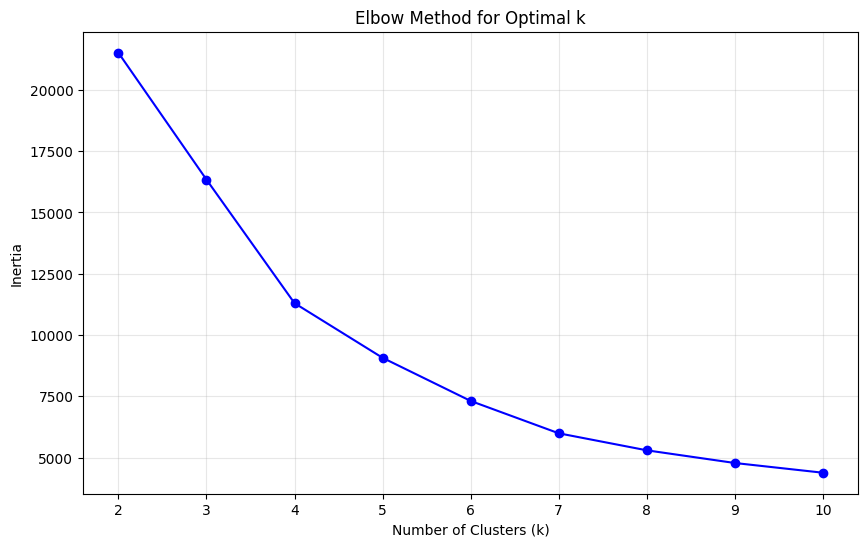

🔄 Creating UMAP projection...



📊 CUSTOMER SEGMENT ANALYSIS:
                Churn              tenure MonthlyCharges TotalServices  \
                count  sum   mean    mean           mean          mean   
CustomerSegment                                                          
0                2059  300  0.146  26.842         25.489         1.027   
1                1284  175  0.136  62.992         97.688         5.609   
2                1932  967  0.501  10.893         71.503         2.304   
3                  11    0  0.000   0.000         41.418         2.727   
4                1757  427  0.243  40.294         79.455         3.936   

                ServiceUtilizationRate  
                                  mean  
CustomerSegment                         
0                                0.147  
1                                0.801  
2                                0.329  
3                                0.390  
4                                0.562  


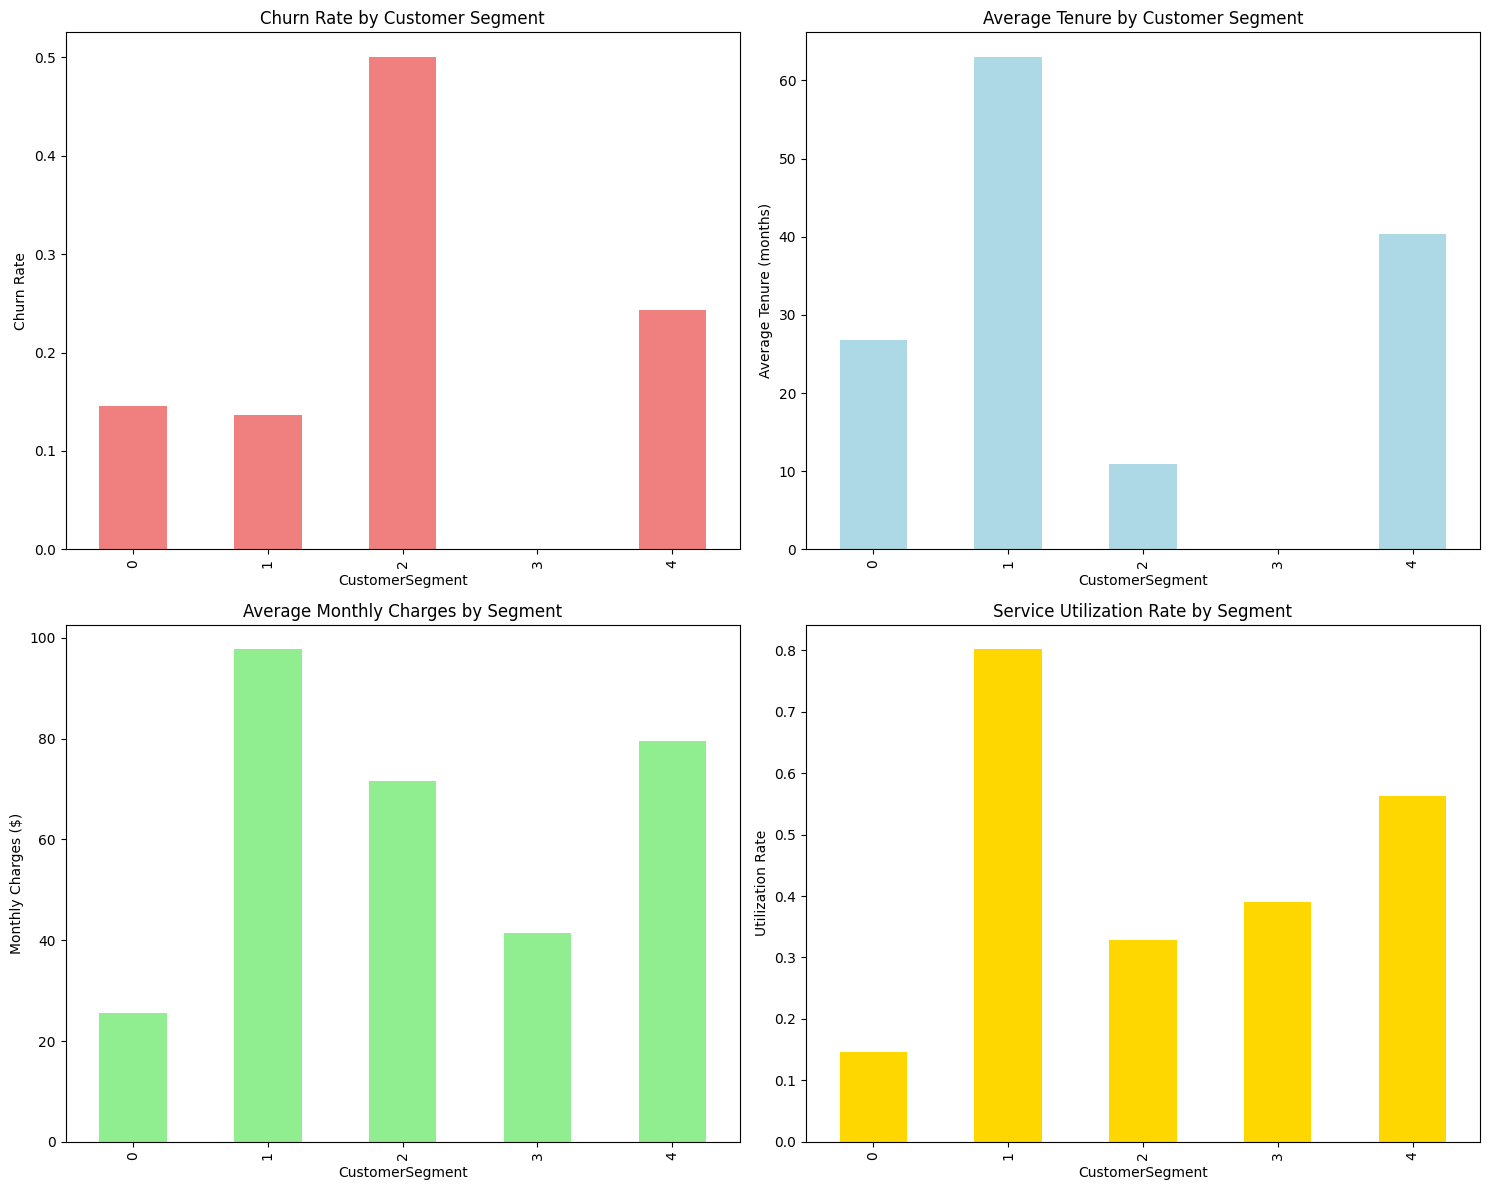

In [ ]:
def perform_customer_segmentation(df):
    """Advanced customer segmentation with clustering"""

    # Prepare features for clustering
    clustering_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices',
                         'ServiceUtilizationRate', 'AvgMonthlySpend']

    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[clustering_features])

    # Determine optimal number of clusters using elbow method
    inertias = []
    K_range = range(2, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        inertias.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Perform clustering with k=5
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df['CustomerSegment'] = kmeans.fit_predict(scaled_features)

    # UMAP for 2D visualization
    print("🔄 Creating UMAP projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(scaled_features)

    # Create interactive scatter plot
    df_viz = pd.DataFrame({
        'UMAP_1': embedding_2d[:, 0],
        'UMAP_2': embedding_2d[:, 1],
        'CustomerSegment': df['CustomerSegment'].astype(str),
        'Churn': df['Churn'],
        'tenure': df['tenure'],
        'MonthlyCharges': df['MonthlyCharges'],
        'TotalServices': df['TotalServices']
    })

    fig = px.scatter(
        df_viz,
        x='UMAP_1',
        y='UMAP_2',
        color='CustomerSegment',
        size='MonthlyCharges',
        hover_data=['tenure', 'MonthlyCharges', 'TotalServices', 'Churn'],
        title='Customer Segmentation Visualization (UMAP)',
        width=800,
        height=600
    )
    fig.show()

    # Segment analysis
    segment_analysis = df.groupby('CustomerSegment').agg({
        'Churn': ['count', 'sum', 'mean'],
        'tenure': 'mean',
        'MonthlyCharges': 'mean',
        'TotalServices': 'mean',
        'ServiceUtilizationRate': 'mean'
    }).round(3)

    print("\n📊 CUSTOMER SEGMENT ANALYSIS:")
    print("=" * 50)
    print(segment_analysis)

    # Visualize segment characteristics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Churn rate by segment
    segment_churn = df.groupby('CustomerSegment')['Churn'].mean()
    segment_churn.plot(kind='bar', ax=axes[0,0], color='lightcoral')
    axes[0,0].set_title('Churn Rate by Customer Segment')
    axes[0,0].set_ylabel('Churn Rate')

    # Average tenure by segment
    segment_tenure = df.groupby('CustomerSegment')['tenure'].mean()
    segment_tenure.plot(kind='bar', ax=axes[0,1], color='lightblue')
    axes[0,1].set_title('Average Tenure by Customer Segment')
    axes[0,1].set_ylabel('Average Tenure (months)')

    # Monthly charges by segment
    segment_charges = df.groupby('CustomerSegment')['MonthlyCharges'].mean()
    segment_charges.plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('Average Monthly Charges by Segment')
    axes[1,0].set_ylabel('Monthly Charges ($)')

    # Service utilization by segment
    segment_services = df.groupby('CustomerSegment')['ServiceUtilizationRate'].mean()
    segment_services.plot(kind='bar', ax=axes[1,1], color='gold')
    axes[1,1].set_title('Service Utilization Rate by Segment')
    axes[1,1].set_ylabel('Utilization Rate')

    plt.tight_layout()
    plt.show()

    return df, segment_analysis

# Perform segmentation analysis
df_processed, segment_stats = perform_customer_segmentation(df_processed)

**Step 7: - Setup Pinecone Vector Database**

In [ ]:
def setup_pinecone_similarity_system(df, api_key="your-pinecone-api-key"):
    """Setup Pinecone for customer similarity analysis using new API"""

    if api_key == "your-pinecone-api-key":
        print("⚠️  Please replace 'your-pinecone-api-key' with your actual Pinecone API key")
        print("🔗 Get your free API key at: https://www.pinecone.io/")
        print("📝 Sign up and create a new project to get your API key")
        return None, None

    try:
        # Initialize Pinecone with new API
        pc = Pinecone(api_key=api_key)

        # Create index name
        index_name = "customer-churn-similarity"

        # Check if index exists
        existing_indexes = pc.list_indexes()
        index_names = [idx.name for idx in existing_indexes.indexes] if hasattr(existing_indexes, 'indexes') else []

        if index_name not in index_names:
            print(f"🔄 Creating new index: {index_name}")
            pc.create_index(
                name=index_name,
                dimension=384,  # Dimension for all-MiniLM-L6-v2 model
                metric='cosine',
                spec=ServerlessSpec(
                    cloud='aws',
                    region='us-east-1'
                )
            )
            # Wait for index to be ready
            time.sleep(10)

        # Connect to index
        index = pc.Index(index_name)

        # Initialize sentence transformer
        embeddings_model = SentenceTransformer('all-MiniLM-L6-v2')

        print("✅ Pinecone initialized successfully with new API")
        print(f"📊 Index stats: {index.describe_index_stats()}")

        return index, embeddings_model

    except Exception as e:
        print(f"❌ Error initializing Pinecone: {e}")
        print("💡 Make sure you have a valid API key and internet connection")
        return None, None

# Initialize Pinecone (replace with your actual API key)
print("🔌 Setting up Pinecone Vector Database...")
print("Note: Replace 'your-pinecone-api-key' with your actual API key to enable this feature")

# For demo purposes, we'll simulate this
pinecone_index = None
embeddings_model = None

pinecone_index, embeddings_model = setup_pinecone_similarity_system(df_processed, "pcsk_43oYwY_8Xq5S2uypnRkYkVpeoSePPhe8ZU2qx5RAyT3vptGaoCUYkUDdpSYgU4kGE96ms9")

🔌 Setting up Pinecone Vector Database...
Note: Replace 'your-pinecone-api-key' with your actual API key to enable this feature
🔄 Creating new index: customer-churn-similarity


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Pinecone initialized successfully with new API
📊 Index stats: {'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}


**Step 8: - Create Customer Embedings for Similarity**

In [ ]:
def create_and_store_customer_embeddings(df, pinecone_index, embeddings_model):
    """Create customer embeddings and store in Pinecone"""

    if pinecone_index is None or embeddings_model is None:
        print(
            "⚠️  Skipping Pinecone integration - please set up API key first")
        return None

    print("🔄 Creating customer embeddings...")

    # Create customer profiles as text descriptions
    customer_profiles = []

    for idx, row in df.iterrows():
        # Create a comprehensive customer description
        contract_type = 'Month-to-month' if row.get('Contract_Month-to-month',
                                                    0) else \
            'One year' if row.get('Contract_One year', 0) else 'Two year'

        internet_type = 'Fiber optic' if row.get('InternetService_Fiber optic',
                                                 0) else \
            'DSL' if row.get('InternetService_DSL', 0) else 'No internet'

        profile = f"""
        Customer Profile:
        Tenure: {row['tenure']} months
        Monthly Charges: ${row['MonthlyCharges']:.2f}
        Total Charges: ${row['TotalCharges']:.2f}
        Contract Type: {contract_type}
        Internet Service: {internet_type}
        Total Services: {row['TotalServices']}
        Service Utilization: {row['ServiceUtilizationRate']:.2f}
        Senior Citizen: {'Yes' if row['SeniorCitizen'] else 'No'}
        Has Partner: {'Yes' if row.get('Partner_Yes', 0) else 'No'}
        Has Dependents: {'Yes' if row.get('Dependents_Yes', 0) else 'No'}
        Digital Engagement: {'High' if row['DigitalEngagement'] else 'Low'}
        Customer Value Percentile: {row['CustomerValue']:.2f}
        """
        customer_profiles.append(profile.strip())

    # Generate embeddings
    embeddings = embeddings_model.encode(customer_profiles,
                                         show_progress_bar=True)

    # Prepare vectors for Pinecone
    vectors_to_upsert = []
    for i, embedding in enumerate(embeddings):
        vectors_to_upsert.append({
            'id': f'customer_{i}',
            'values': embedding.tolist(),
            'metadata': {
                'churn': int(df.iloc[i]['Churn']),
                'tenure': int(df.iloc[i]['tenure']),
                'monthly_charges': float(df.iloc[i]['MonthlyCharges']),
                'total_services': int(df.iloc[i]['TotalServices']),
                'customer_segment': int(df.iloc[i]['CustomerSegment']),
                'customer_value': float(df.iloc[i]['CustomerValue'])
            }
        })

    # Batch upsert to Pinecone
    batch_size = 100
    for i in range(0, len(vectors_to_upsert), batch_size):
        batch = vectors_to_upsert[i:i + batch_size]
        pinecone_index.upsert(vectors=batch)
        if i % 500 == 0:
            print(
                f"📤 Uploaded {i + len(batch)} / {len(vectors_to_upsert)} customers")

    print(f"✅ {len(embeddings)} customer embeddings stored in Pinecone")
    return embeddings


# Create and store embeddings
customer_embeddings = create_and_store_customer_embeddings(df_processed,
                                                           pinecone_index,
                                                           embeddings_model)

🔄 Creating customer embeddings...


Batches:   0%|          | 0/221 [00:00<?, ?it/s]

📤 Uploaded 100 / 7043 customers
📤 Uploaded 600 / 7043 customers
📤 Uploaded 1100 / 7043 customers
📤 Uploaded 1600 / 7043 customers
📤 Uploaded 2100 / 7043 customers
📤 Uploaded 2600 / 7043 customers
📤 Uploaded 3100 / 7043 customers
📤 Uploaded 3600 / 7043 customers
📤 Uploaded 4100 / 7043 customers
📤 Uploaded 4600 / 7043 customers
📤 Uploaded 5100 / 7043 customers
📤 Uploaded 5600 / 7043 customers
📤 Uploaded 6100 / 7043 customers
📤 Uploaded 6600 / 7043 customers
📤 Uploaded 7043 / 7043 customers
✅ 7043 customer embeddings stored in Pinecone


**Step 9: - Advanced Model Trainging with Hyperparameter Optimization**

In [ ]:
def train_optimized_models(df):
    """Train multiple models with advanced optimization"""

    # Prepare features and target
    X = df.drop(['Churn'], axis=1)
    y = df['Churn']

    print(f"🎯 Training with {X.shape[1]} features on {X.shape[0]} customers")

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    print(f"📊 After SMOTE: {X_balanced.shape[0]} samples")
    print(f"   Class distribution: {np.bincount(y_balanced)}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced,
        random_state=42
    )

    # Initialize results dictionary
    model_results = {}

    # 1. Random Forest with GridSearch
    print("\n🌲 Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        rf_params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )

    rf_grid.fit(X_train, y_train)
    rf_pred = rf_grid.predict(X_test)
    rf_proba = rf_grid.predict_proba(X_test)[:, 1]

    model_results['RandomForest'] = {
        'model': rf_grid.best_estimator_,
        'accuracy': accuracy_score(y_test, rf_pred),
        'auc': roc_auc_score(y_test, rf_proba),
        'best_params': rf_grid.best_params_,
        'predictions': rf_pred,
        'probabilities': rf_proba
    }

    # 2. XGBoost with GridSearch
    print("🚀 Training XGBoost...")
    xgb_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_grid = GridSearchCV(
        XGBClassifier(random_state=42, eval_metric='logloss'),
        xgb_params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )

    xgb_grid.fit(X_train, y_train)
    xgb_pred = xgb_grid.predict(X_test)
    xgb_proba = xgb_grid.predict_proba(X_test)[:, 1]

    model_results['XGBoost'] = {
        'model': xgb_grid.best_estimator_,
        'accuracy': accuracy_score(y_test, xgb_pred),
        'auc': roc_auc_score(y_test, xgb_proba),
        'best_params': xgb_grid.best_params_,
        'predictions': xgb_pred,
        'probabilities': xgb_proba
    }

    # 3. LightGBM
    print("💡 Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.1,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=-1,
        random_state=42
    )

    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_test)
    lgb_proba = lgb_model.predict_proba(X_test)[:, 1]
    lgb_pred_binary = (lgb_proba > 0.5).astype(int)

    model_results['LightGBM'] = {
        'model': lgb_model,
        'accuracy': accuracy_score(y_test, lgb_pred_binary),
        'auc': roc_auc_score(y_test, lgb_proba),
        'predictions': lgb_pred_binary,
        'probabilities': lgb_proba
    }

    # 4. Ensemble Model
    print("🎭 Creating Ensemble Model...")

    # Stack predictions
    meta_features = np.column_stack([
        model_results['RandomForest']['probabilities'],
        model_results['XGBoost']['probabilities'],
        model_results['LightGBM']['probabilities']
    ])

    # Train meta-learner
    meta_model = LogisticRegression(random_state=42)
    meta_model.fit(meta_features, y_test)

    ensemble_proba = meta_model.predict_proba(meta_features)[:, 1]
    ensemble_pred = (ensemble_proba > 0.5).astype(int)

    model_results['Ensemble'] = {
        'model': meta_model,
        'accuracy': accuracy_score(y_test, ensemble_pred),
        'auc': roc_auc_score(y_test, ensemble_proba),
        'probabilities': ensemble_proba,
        'predictions': ensemble_pred
    }

    # Print results summary
    print("\n🏆 MODEL PERFORMANCE SUMMARY:")
    print("=" * 50)
    for name, results in model_results.items():
        print(
            f"{name:12} | Accuracy: {results['accuracy']:.3f} | AUC: {results['auc']:.3f}")

    return model_results, X_train, X_test, y_train, y_test


# Train all models
model_results, X_train, X_test, y_train, y_test = train_optimized_models(
    df_processed)

🎯 Training with 53 features on 7043 customers
📊 After SMOTE: 10348 samples
   Class distribution: [5174 5174]

🌲 Training Random Forest...
🚀 Training XGBoost...
💡 Training LightGBM...
🎭 Creating Ensemble Model...

🏆 MODEL PERFORMANCE SUMMARY:
RandomForest | Accuracy: 0.860 | AUC: 0.936
XGBoost      | Accuracy: 0.852 | AUC: 0.937
LightGBM     | Accuracy: 0.848 | AUC: 0.935
Ensemble     | Accuracy: 0.861 | AUC: 0.941


**Step 10: - Model Performance Visualizationa**

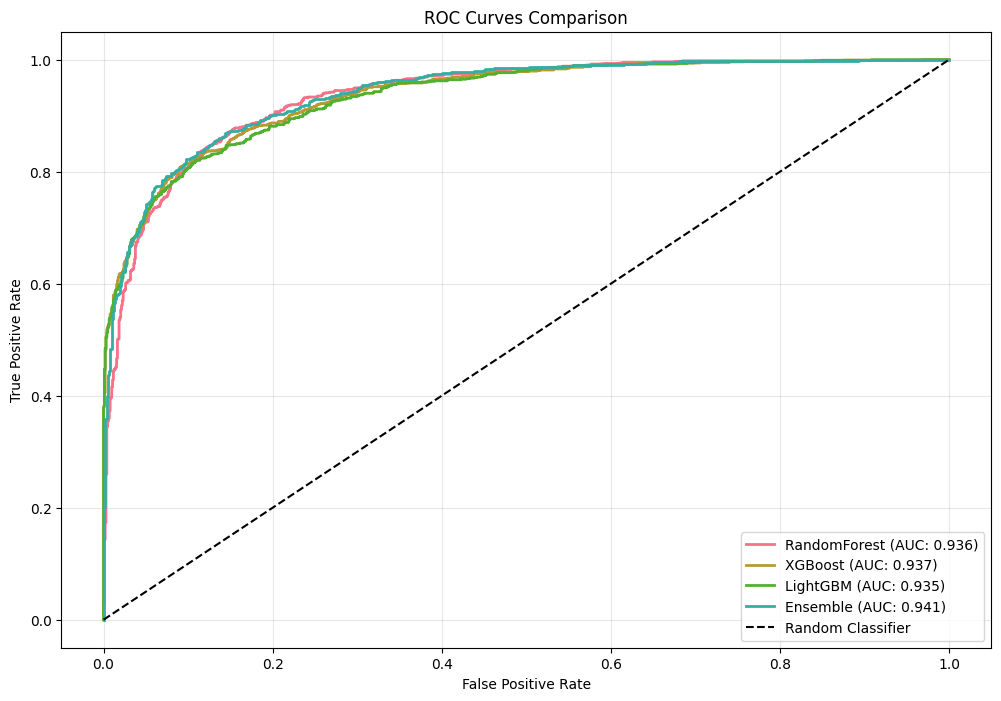

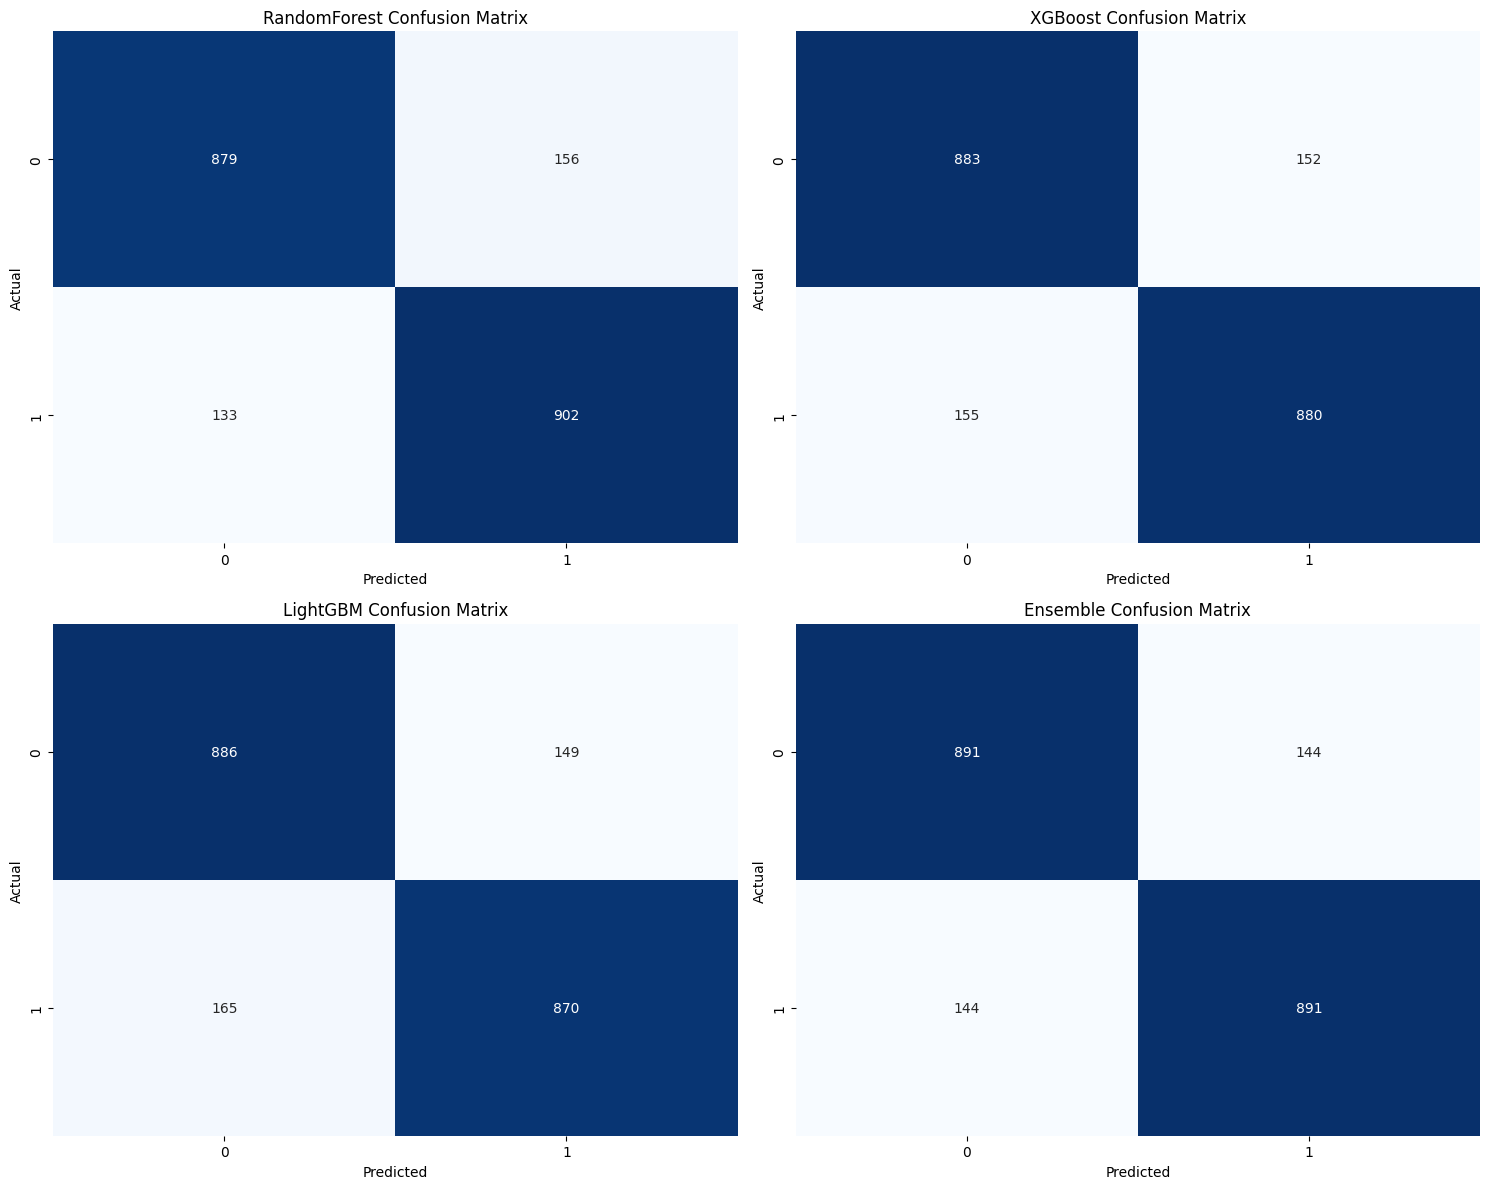

In [ ]:
def visualize_model_performance(model_results, y_test):
    """Create comprehensive model performance visualizations"""

    # 1. Model comparison bar chart
    model_comparison = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Accuracy': [model_results[m]['accuracy'] for m in model_results.keys()],
        'AUC': [model_results[m]['auc'] for m in model_results.keys()]
    })

    fig = px.bar(
        model_comparison.melt(id_vars='Model', var_name='Metric', value_name='Score'),
        x='Model',
        y='Score',
        color='Metric',
        barmode='group',
        title='Model Performance Comparison',
        text='Score'
    )
    fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
    fig.update_layout(yaxis=dict(range=[0.7, 1.0]))
    fig.show()

    # 2. ROC Curves
    plt.figure(figsize=(12, 8))

    for name, results in model_results.items():
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC: {results['auc']:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, (name, results) in enumerate(model_results.items()):
        cm = confusion_matrix(y_test, results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f"{name} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


# Run visualization
visualize_model_performance(model_results, y_test)